## Proyecto Final Redes Neuronales

- Martínez Cano Ricardo Iván 
- Victoria Morales Ricardo Maximiliano

In [8]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import glob
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader    


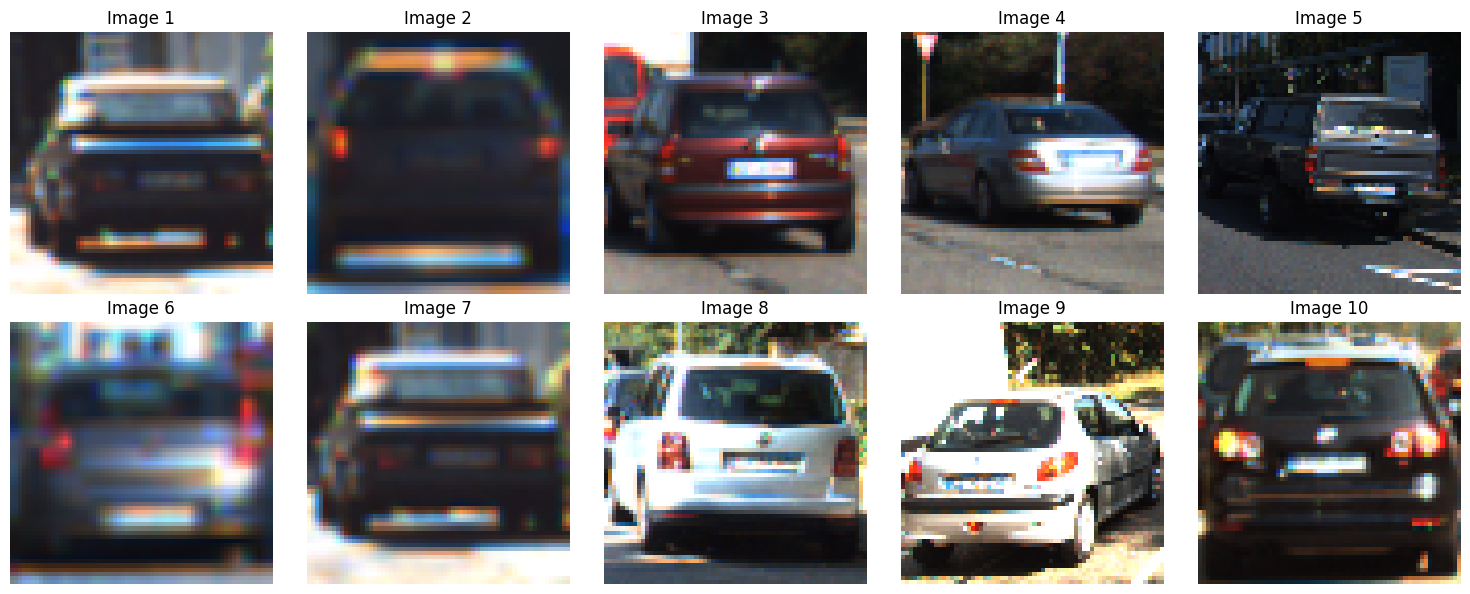

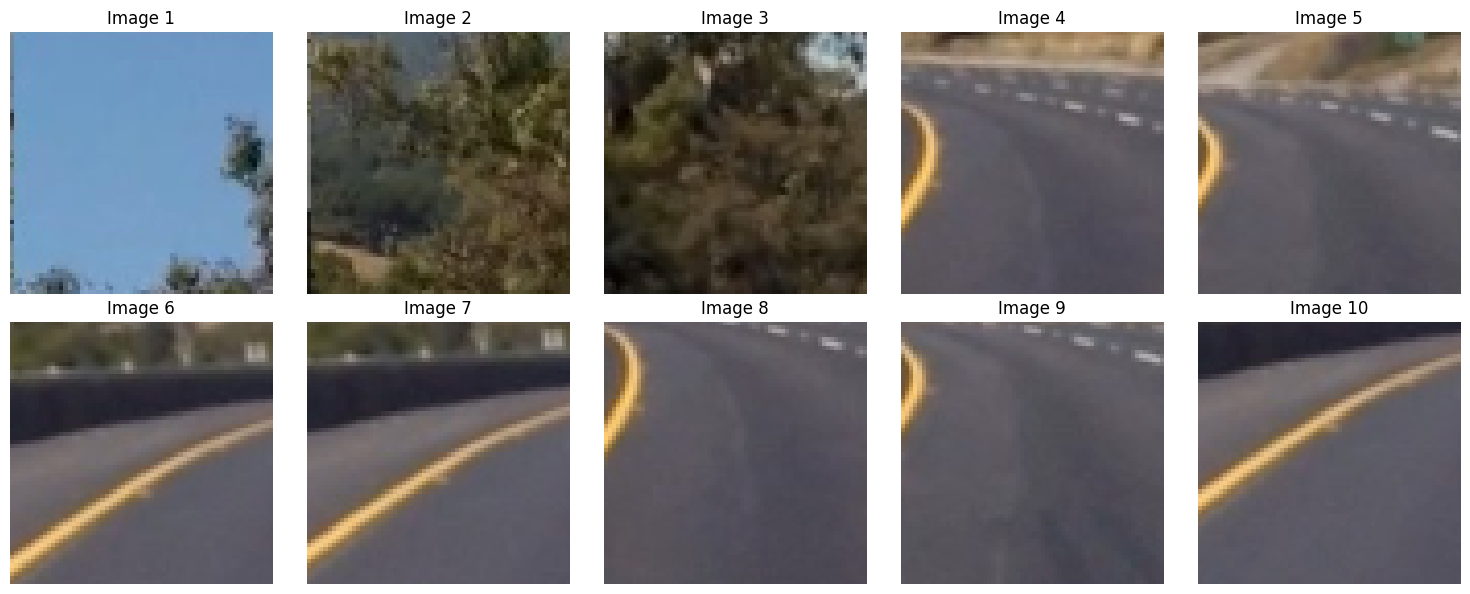

Total vehicle images: 8792
Total non-vehicle images: 8968


In [6]:
# Obtener directorios de datos
vehicle_dir = os.path.join(os.getcwd(), 'data', 'vehicles')
non_vehicle_dir = os.path.join(os.getcwd(), 'data', 'non-vehicles')

# Verificar si los directorios existen
if not os.path.exists(vehicle_dir):
    raise FileNotFoundError(f"Vehicle images directory does not exist: {vehicle_dir}")
if not os.path.exists(non_vehicle_dir):
    raise FileNotFoundError(f"Non-vehicle images directory does not exist: {non_vehicle_dir}")

def load_images(directory):
    """
    Carga imágenes de un directorio específico.
    """
    images = []
    for filename in glob.glob(os.path.join(directory, '*.png')):
        img = cv2.imread(filename)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB
            images.append(img)
    return images

def display_images(images, ncols=5):
    """
    Muestra un conjunto de imágenes en una cuadrícula.
    """
    n_images = len(images)
    n_rows = (n_images + ncols - 1) // ncols  # Calcular número de filas
    fig, axes = plt.subplots(n_rows, ncols, figsize=(15, 3 * n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes]
    
    for ax in axes:
        ax.axis('off')  # Ocultar ejes
    for i, img in enumerate(images):
        axes[i].imshow(img)
        axes[i].set_title(f'Image {i+1}')
    
    plt.tight_layout()
    plt.show()

# Cargar imágenes de vehículos y no vehículos
vehicle_images = load_images(vehicle_dir)
non_vehicle_images = load_images(non_vehicle_dir)

# Mostrar algunas imágenes de vehículos y no vehículos
display_images(vehicle_images[:10], ncols=5)
display_images(non_vehicle_images[:10], ncols=5)

# Verificar la cantidad de imágenes cargadas
print(f"Total vehicle images: {len(vehicle_images)}")
print(f"Total non-vehicle images: {len(non_vehicle_images)}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


Total dataset size: 17760 images


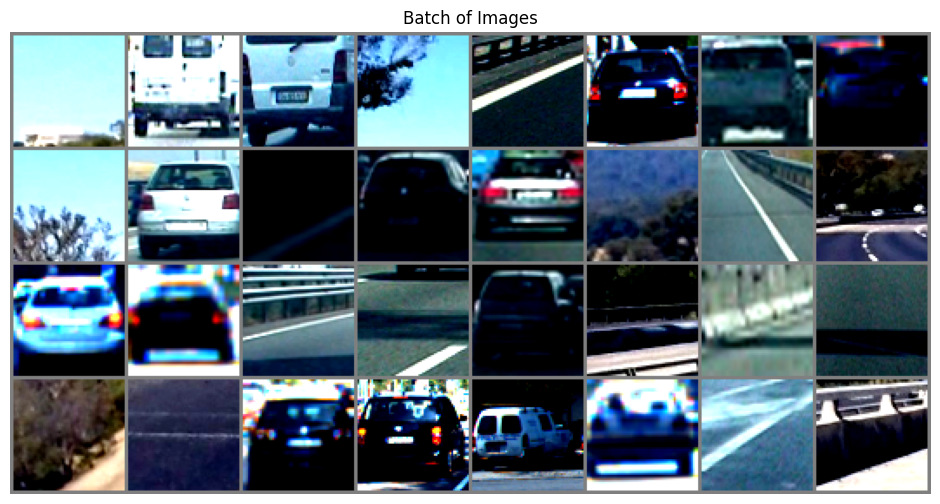

In [ ]:
# Transformar imagenes a tensores y normalizar

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),  # Redimensionar a 64x64
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class VehicleDataset(Dataset):
    def __init__(self, vehicle_images, non_vehicle_images, transform=None):
        self.vehicle_images = vehicle_images
        self.non_vehicle_images = non_vehicle_images
        self.transform = transform
        self.labels = [1] * len(vehicle_images) + [0] * len(non_vehicle_images)
        self.images = vehicle_images + non_vehicle_images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label 

# Crear dataset y dataloader
vehicle_dataset = VehicleDataset(vehicle_images, non_vehicle_images, transform=transform)
vehicle_dataloader = DataLoader(vehicle_dataset, batch_size=32, shuffle=True)

# Verificar el tamaño del dataset
print(f"Total dataset size: {len(vehicle_dataset)} images")

# Visualizar algunas imágenes transformadas
def show_batch(dataloader):
    images, labels = next(iter(dataloader))
    grid_img = tv.utils.make_grid(images, nrow=8)
    grid_img = grid_img / 2 + 0.5  # Desnormalizar para visualización 
    plt.figure(figsize=(12, 6))
    plt.imshow(grid_img.permute(1, 2, 0).numpy())
    plt.title('Batch of Images')
    plt.axis('off')
    plt.show()

show_batch(vehicle_dataloader)



In [ ]:
class CNN(nn.Module): 
    def __init__(self): 
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 3 * 3, 384)
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = x.view(-1, 32 * 3 * 3)  

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x
    
    def train(self, epochs, data_loader, criterion, optimizer, cuda = False):
        losses = []
        for epoch in epochs: 
            running_loss = 0.0
            for i, data in enumerate(data_loader, 0): 
                if(cuda and torch.cuda.is_available()): 
                    inputs, labels = inputs.cuda(), labels.cuda()
                
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            epoch_loss = running_loss / len(data_loader)
            losses.append(epoch_loss)
            print(f'Ciclo {epoch+1}/{len(epochs)}, Perdida: {epoch_loss:.4f}')

        plt.plot(epochs, losses, label='Perdida durante el entrenamiento')
        plt.grid()
        plt.xlabel('Ciclos')
        plt.ylabel('Perdida')
        plt.title('Perdida durante el entrenamiento')
        plt.show()
        plt.legend()

        return losses
